# Ford GoBike System Data (Slide Deck) 

## Investigation Overview

> My choice for analysis was the GoBike dataset to investigate the bike hiring trend in SF. The main focus was on trip duration, start time and season to get our own insights.

## Dataset Overview

> The data consisted of 16 different variables such as age, gender, weekday, time and others. It contains 3.31 billion rides. Ages in dataset from 18 to 56 takes 95% of the users in dataset. There were users more than 100 years old. So, we can remove users more than 60 years old.

> The data contains various and interesting infromation from age and gender to trip duration and start and end time of trip. I only extract 10% of the datasets not all of them due to memory usage performance. Ages in the dataset are ranging from 18 to 56 takes around 95% of the users in dataset.

In [1]:
# import all packages and set plots to be embedded inline
import os
import time
import glob
import numpy as np
import pandas as pd
import helpers as hp
import plotly.express as px
import plotly.graph_objects as go

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Reading all csv files at once and append them at one dataframe
path = r"D:\GitLabRepos\GoBike\gobike"
all_files = glob.glob(os.path.join(path, "*.csv"))
print("Concatincating files to one file...")
start_time = time.time()
df = pd.concat(
    (pd.read_csv(
        file, parse_dates=['start_time', 'end_time', 'member_birth_year'],
        dtype={"start_station_id":"O", "end_station_id":"O", "bike_id":"O"},
        nrows=10000
    ) for file in all_files), ignore_index=True
)

# do some data cleaning : drop nan , remove some insignificant features, adding trip duration in minutes feature 
df.drop(['start_station_latitude','start_station_longitude', 'end_station_latitude', 'end_station_longitude'], axis=1, inplace=True)
df.dropna(inplace=True)

# adding new columns that help in answering the questions precisely
df["duration_min"] = df["duration_sec"] / 60
df['duration_min_log'] = np.log10(df['duration_min'])
df['start_month'], df['start_day'], df['start_hour'] = (
    df['start_time'].dt.month_name(),
    df['start_time'].dt.day_name(),
    df['start_time'].dt.hour,
)
df["season"] = df.apply(hp.seasons, axis=1)  


end_time = time.time()
print("done!")
print("It tooks {} seconds to read, concatnate and wrangle datasets".format(round(end_time - start_time, 2)))
df.head()

Concatincating files to one file...
done!
It tooks 3.51 seconds to read, concatnate and wrangle datasets


,duration_sec,start_time,end_time,start_station_id,start_station_name,end_station_id,end_station_name,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_min,duration_min_log,start_month,start_day,start_hour,season
0,59088,2018-06-30 23:32:44.659,2018-07-01 15:57:33.316,76,McCoppin St at Valencia St,95,Sanchez St at 15th St,2100,Subscriber,1975-01-01,Male,Yes,984.800000,2.993348,June,Saturday,23,Summer
2,63654,2018-06-30 20:26:53.031,2018-07-01 14:07:47.232,23,The Embarcadero at Steuart St,50,2nd St at Townsend St,3235,Subscriber,1962-01-01,Female,No,1060.900000,3.025674,June,Saturday,20,Summer
3,50508,2018-06-30 20:29:59.813,2018-07-01 10:31:48.250,58,Market St at 10th St,88,11th St at Bryant St,3675,Subscriber,1992-01-01,Male,No,841.800000,2.925209,June,Saturday,20,Summer
4,51697,2018-06-30 18:24:56.696,2018-07-01 08:46:33.739,196,Grand Ave at Perkins St,272,Woolsey St at Sacramento St,3232,Customer,1989-01-01,Female,No,861.616667,2.935314,June,Saturday,18,Summer
7,7224,2018-06-30 23:01:00.400,2018-07-01 01:01:24.433,284,Yerba Buena Center for the Arts (Howard St at ...,284,Yerba Buena Center for the Arts (Howard St at ...,779,Subscriber,1989-01-01,Male,No,120.400000,2.080626,June,Saturday,23,Summer


> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## (Visualization 1)

> #### Question 1 : What is the average trip duration?

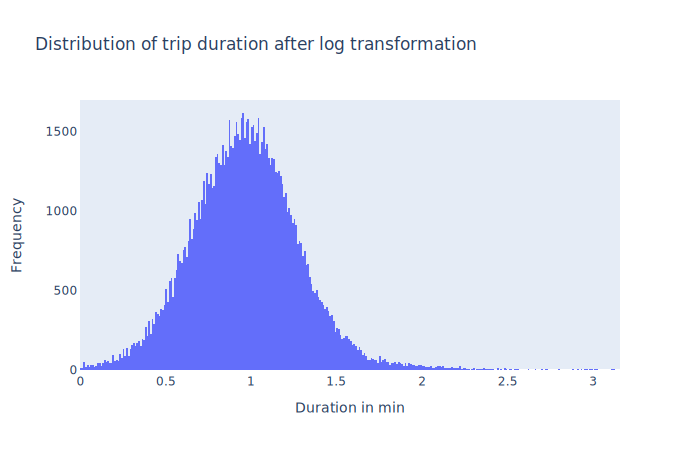

In [3]:
# Let's plot the distribution of trip duration.  
data = go.Histogram(x=df["duration_min_log"])
layout = go.Layout(
    title="Distribution of trip duration after log transformation",
    xaxis={"showgrid":False, "title":"Duration in min"},
    yaxis= {"showgrid":False, "title":"Frequency"}
)
fig = go.Figure(data, layout)
fig.show(renderer='svg')

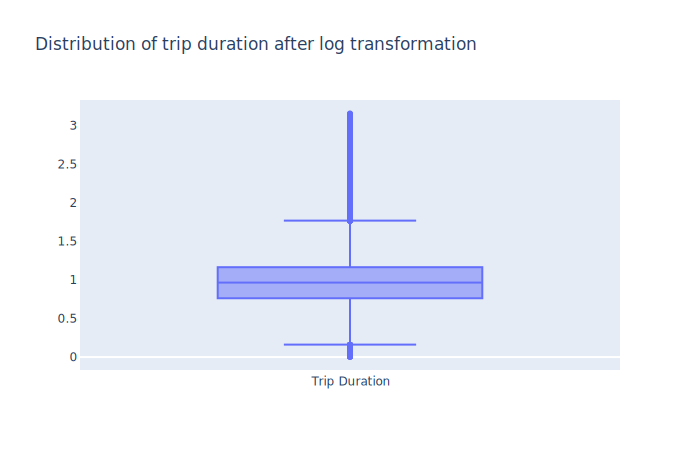

In [4]:
# presenting the 5 number summary
data = go.Box(y=df["duration_min_log"], name="Trip Duration")
layout = go.Layout(
    title="Distribution of trip duration after log transformation", xaxis={"showgrid":False}, yaxis= {"showgrid":False}
)
fig = go.Figure(data, layout)
fig.show(renderer='svg')

> #### Conclusion 1 : As seen before, it is difficult to read the plot in trip duration per second so that I tend to perform log transformation based on base 10 to plot a normally distributed shape and answer the question precisely. It looks like that most of the trips takes 10 minutes in average - short trips.

## (Visualization 2)

> #### Question 2.  Is season a factor to affect on trip duration?

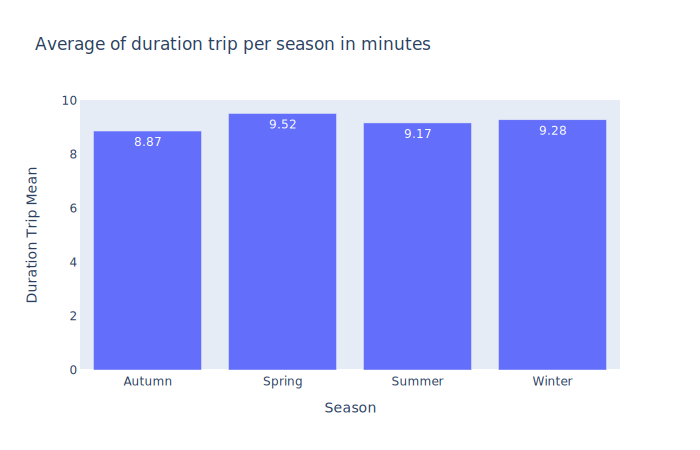

In [5]:
# seasons vs median duration trips
season_duration_mean = df.groupby('season')['duration_min'].median().reset_index()
fig = go.Figure(
    go.Bar(
        x=season_duration_mean['season'].tolist(),
        y=season_duration_mean['duration_min'].tolist(),
        text=round(season_duration_mean['duration_min'], 2).astype(str).tolist(),
        textposition="auto"
    ),
    go.Layout(
        title="Average of duration trip per season in minutes",
        xaxis={"showgrid":False, "title":"Season"},
        yaxis={"showgrid":False, "title":"Duration Trip Mean"}
    )
)
fig.show(renderer='svg')

> #### Conclusion 2 : Due to outliers that exit heavily in this data, I chose to measure the average by median not mean to not mislead the results. Despite there is no significant difference in trip dutaion across seasons, the plot appears that spring has the longest median of trip duration. This was expected for me as in spring we have a very relxing whether experience that motivates going bicycling. Whether doesn't affect that much in SF. I don't know why but this might go back to unchanging extreme whether conditions.

## (Visualization 3)

> #### Question 3. Is season vs months/days a factor of interest to affect on trip duration?


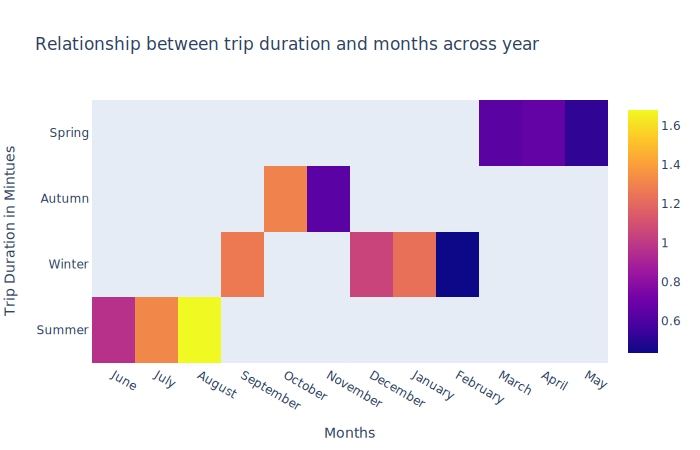

In [6]:
fig = go.Figure(
    go.Heatmap(
        z=df['duration_min_log'].tolist(),
        x=df['start_month'].tolist(),
        y=df['season'].tolist(),
        # hoverongaps = False
    ),
    go.Layout(
        title="Relationship between trip duration and months across year",
        xaxis={"showgrid":False, "title":"Months"},
        yaxis={"showgrid":False, "title":"Trip Duration in Mintues"},
        xaxis_type="category"
    )
)
fig.show(renderer='svg')

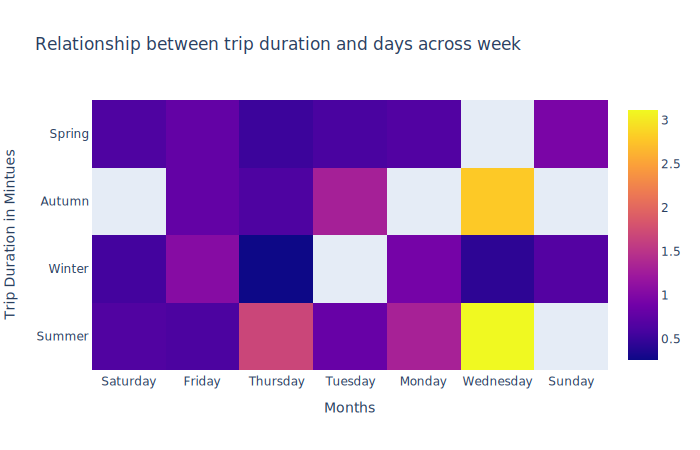

In [7]:
fig = go.Figure(
    go.Heatmap(
        z=df['duration_min_log'].tolist(),
        x=df['start_day'].tolist(),
        y=df['season'].tolist(),
        # hoverongaps = False
    ),
    go.Layout(
        title="Relationship between trip duration and days across week",
        xaxis={"showgrid":False, "title":"Months"},
        yaxis={"showgrid":False, "title":"Trip Duration in Mintues"},
        xaxis_type="category"
    )
)
fig.show(renderer='svg')

> #### Conclusion 3 : I've created season column that to plot multivariate exploration between season, months and trip duration. From the heatmap above, we can see that longest trip durations are in the summer specifically in August. Winter, in Sep and Jan, comes in the second place, while spring months come with shortest trip durations across the year. Unlike the previous bar chart that shows the longest median duratoin trip is in spring, the heatmap suggests the summer as duration count with longest ones. The second heatmap also prove the same fact that the summer has the peak duration of trips with high frequency in Wednesdays.

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!